# Assignment 3

## Yosemite Village Yearly Weather
*Temperature is cyclical, not only on a 24 hour basis but also on a yearly basis. Convert the dataset into a richer format whereby the day of the year is also captured. For example the time “20150212 1605”, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.*

*This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
from sklearn import linear_model
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, \
r2_score, mean_absolute_error, median_absolute_error

First, I imported and formatted the datasets.

In [2]:
# import datasets
years = range(2011, 2017)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
usecols = [1, 2, 8]

data = [np.loadtxt(f, usecols=usecols) for f in files]
data = np.vstack(data)

# Map from HHmm to an integer
data[:, 1] = np.floor_divide(data[:, 1], 100) * 60 + np.mod(data[:, 1], 100)

In [3]:
# create dataframe
cols = ['Date', 'Minute', 'Temp']
df = pd.DataFrame(data, columns=cols)

# convert date to datetime
df['Date'] = df['Date'].astype(str)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y%m%d')

# save day of year
df['DoY'] = [pd.Period(i, freq='H') for i in df['Date']]
df['DoY'] = [i.dayofyear for i in df['DoY']]

# drop temperature values below -1000
df = df[df['Temp'] > -1000]

df

,Date,Minute,Temp,DoY
0,2011-01-01,5.0,-6.4,1
1,2011-01-01,10.0,-6.5,1
2,2011-01-01,15.0,-6.5,1
3,2011-01-01,20.0,-6.5,1
4,2011-01-01,25.0,-6.7,1
...,...,...,...,...
631291,2016-12-31,1420.0,0.3,366
631292,2016-12-31,1425.0,0.2,366
631293,2016-12-31,1430.0,0.0,366
631294,2016-12-31,1435.0,-0.1,366


Next, I split the formatted dataframe into test and training sets.

In [4]:
# split into train and test sets by year
training = df[df['Date'] <= '2015-01-01']
training['Date'] = training['Date'].map(datetime.datetime.toordinal)

testing = df[df['Date'] > '2015-01-01']
testing['Date'] = testing['Date'].map(datetime.datetime.toordinal)

# define X and Y variables
X_train = training.drop(columns=['Temp'])
y_train = training['Temp']
X_test = testing.drop(columns=['Temp'])
y_test = testing['Temp']

/Users/sarahpoisner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sarahpoisner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1. *Cover each input dimension with a list of radial basis functions. This turns the pair of inputs into a much richer representation, mapping $(d,t)$ into $(\Phi_1(d), \Phi_2(t))$. Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions.*

I defined a function that trains and tests a Ridge Regression model using training and testing data from training and testing datasets defined above. The function outputs the score, MSE (Mean Squared Error), MAS (Mean Absolute), and Median Absolute Error of the model when applied to the testing data.

In [5]:
# define Radial Basis Function (RBF)

def Yosemite_RBF(X_variable, sigma, alpha, RBFs):
    
    
    ### Train on Train Set ###
    
    # re-format X-values (train)
    X_train_copy = np.array(X_train[X_variable].values)
    X_train_copy = X_train_copy.reshape(-1,1)
    
    # define RBF centers
    centers = np.linspace(X_train_copy.min(), 
                          X_train_copy.max(), 
                          RBFs).reshape(-1, 1)
    
    # create new representation of X for RBF using centers
    x_kernel = rbf_kernel(X_train_copy, centers, gamma=1.0/sigma)

    # fit a Ridge model between X and y
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(x_kernel, y_train)
    
    # create new RBF representation to make predictions (train)
    all_x_train = np.linspace(X_train_copy.min(), 
                              X_train_copy.max(), 
                              len(y_train)).reshape(-1, 1)
    expanded_x_train = rbf_kernel(all_x_train, 
                                  centers, gamma=1.0/sigma)
    y_pred_train = ridge.predict(expanded_x_train)
    
    
    ### Test on Test Set ###
    
    # re-format X-values (test)
    X_test_copy = np.array(X_test[X_variable].values)
    X_test_copy = X_test_copy.reshape(-1,1)
    
    # create new RBF representation to make predictions (test)
    x_kernel_test = rbf_kernel(X_test_copy, centers, gamma = 1/sigma)
    all_x_test = np.linspace(X_test_copy.min(), 
                             X_test_copy.max(), 
                             len(y_test)).reshape(-1, 1)
    expanded_x_test = rbf_kernel(all_x_test, 
                                  centers, gamma=1.0/sigma)
    y_pred_test = ridge.predict(expanded_x_test)

    
    # calculate metrics for test set
    score = ridge.score(x_kernel_test, y_test)
    MSE = mean_squared_error(y_test, y_pred_test)
    MAE = mean_absolute_error(y_test, y_pred_test)
    MedAE = median_absolute_error(y_test, y_pred_test)
        
    
    # return all results
    return X_variable, sigma, alpha, RBFs, \
score, MSE, MAE, MedAE, all_x_train, y_pred_train, all_x_test, y_pred_test


I ran the model and computed the test metrics for different values of sigma, alpha, and RBF count to select which values resulted in the best metrics for both Day of Year (DoY) and Time (in minutes).

In [6]:
# test seasonal Ridge model for different sigmas, alphas, RBFs

sigmas = [1, 10, 100]
alphas = [1, 10, 100]
RBFs = [100, 200, 400]

DoY_results = []
for sigma in sigmas:
    for alpha in alphas:
        for RBF in RBFs:
            result = Yosemite_RBF('DoY', sigma, alpha, RBF)
            DoY_results.append(result[1:8])

In [7]:
# create dataframe
cols = ['sigma', 'alpha', 'RBFs', 'score', 'MSE', 'MAE', 'MedAE']
DoY_results_df = pd.DataFrame(DoY_results, columns=cols)
DoY_results_df

,sigma,alpha,RBFs,score,MSE,MAE,MedAE
0,1,1,100,-0.269704,129.005592,9.414748,8.538550
1,1,1,200,0.459487,114.961352,8.939993,8.184556
2,1,1,400,0.466861,115.044274,8.936923,8.191122
3,1,10,100,-0.269498,128.655820,9.406687,8.541263
4,1,10,200,0.459753,114.569137,8.929978,8.183003
5,1,10,400,0.467271,114.833849,8.931478,8.190633
6,1,100,100,-0.273528,125.733921,9.338157,8.581746
7,1,100,200,0.457367,111.123896,8.840267,8.178744
8,1,100,400,0.468792,112.909534,8.881573,8.202828
9,10,1,100,0.476162,114.224639,8.896453,8.159927


In [8]:
# test daily Ridge model for different sigmas, alphas, RBFs

sigmas = [1, 10, 100]
alphas = [1, 10, 100]
RBFs = [100, 200, 400]

Min_results = []
for sigma in sigmas:
    for alpha in alphas:
        for RBF in RBFs:
            result = Yosemite_RBF('Minute', sigma, alpha, RBF)
            Min_results.append(result[1:8])

In [9]:
# create dataframe
cols = ['sigma', 'alpha', 'RBFs', 'score', 'MSE', 'MAE', 'MedAE']
Min_results_df = pd.DataFrame(Min_results, columns=cols)
Min_results_df

,sigma,alpha,RBFs,score,MSE,MAE,MedAE
0,1,1,100,-1.299079,710.733198,15.299082,10.596460
1,1,1,200,-0.773159,1233.359907,19.499180,10.597976
2,1,1,400,0.035759,689.607279,16.145059,9.460054
3,1,10,100,-1.381697,187.546091,11.143474,9.999649
4,1,10,200,-0.939407,203.212038,11.154122,9.399697
5,1,10,400,-0.088921,231.462184,11.280473,8.613400
6,1,100,100,-1.484464,153.712396,10.424378,9.697833
7,1,100,200,-1.145088,138.517020,9.751211,8.699135
8,1,100,400,-0.467300,111.403106,8.658323,7.536476
9,10,1,100,-0.769435,108.367014,8.542352,7.509862


In [10]:
# test all dates Ridge model for different sigmas, alphas, RBFs

sigmas = [1, 10, 100]
alphas = [1, 10, 100]
RBFs = [100, 200, 400]

date_results = []
for sigma in sigmas:
    for alpha in alphas:
        for RBF in RBFs:
            result = Yosemite_RBF('Date', sigma, alpha, RBF)
            date_results.append(result[1:8])

In [11]:
# create dataframe
cols = ['sigma', 'alpha', 'RBFs', 'score', 'MSE', 'MAE', 'MedAE']
date_results_df = pd.DataFrame(date_results, columns=cols)
date_results_df

,sigma,alpha,RBFs,score,MSE,MAE,MedAE
0,1,1,100,-1.828983,166.507562,10.943750,10.300000
1,1,1,200,-1.828983,166.507562,10.943750,10.300000
2,1,1,400,-1.828983,166.507563,10.943750,10.300000
3,1,10,100,-1.828982,166.507552,10.943747,10.300000
4,1,10,200,-1.828982,166.507552,10.943747,10.300000
5,1,10,400,-1.828982,166.507553,10.943748,10.300000
6,1,100,100,-1.828974,166.507478,10.943735,10.300000
7,1,100,200,-1.828974,166.507478,10.943735,10.300000
8,1,100,400,-1.828974,166.507479,10.943735,10.300000
9,10,1,100,-1.830365,166.564294,10.949285,10.300000


2. *Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.*

The combination of variables that resulted in the least error for Day of Year for the testing data was sigma = 1, alpha = 100, RBFs = 200. The combination of variables that resulted in the least error for Minute for the testing data was sigma = 100, alpha = 10, RBFs = 400. The combination of variables that resulted in the least error for all dates for the testing data was sigma = 1, alpha = 100, RBFs = 200. Therefore I chose to use these variables to build the linear parameter models for the seasonal, daily, and all dates model variations.

In [12]:
# apply Ridge Regression using seasonal data
seasonal_model = Yosemite_RBF('DoY', 1, 100, 200)

# apply Ridge Regression using daily (minutes) data
daily_model = Yosemite_RBF('Minute', 100, 10, 400)

# apply Ridge Regression using all dates data
all_dates_model = Yosemite_RBF('Date', 1, 100, 200)

3. *Create two plots, one showing the time-of-day contribution, and one showing the time-of-year contribution.*

I created plots for the seasonal, daily, and all dates models.

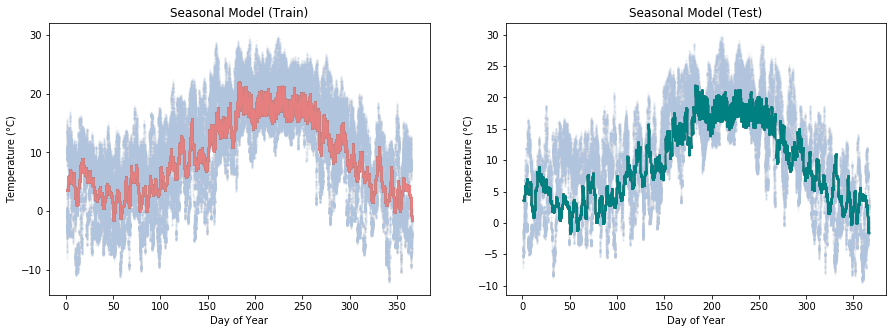

In [13]:
# plot seasonal model
fig, axs = plt.subplots(1, 2, figsize=(15,5))

# Training Data
axs[0].scatter(X_train['DoY'], y_train, 
               color='lightsteelblue', alpha=0.1, s = 0.5)
axs[0].scatter(seasonal_model[8], seasonal_model[9], 
               alpha=0.1, s=0.5, color='lightcoral')
axs[0].set_title('Seasonal Model (Train)')
axs[0].set_xlabel('Day of Year')
axs[0].set_ylabel('Temperature (°C)')

# Testing Data
axs[1].scatter(X_test['DoY'], y_test, 
               color='lightsteelblue', alpha=0.1, s = 0.5)
axs[1].scatter(seasonal_model[10], seasonal_model[11], 
               alpha=0.1, s=0.5, color='teal')
axs[1].set_title('Seasonal Model (Test)')
axs[1].set_xlabel('Day of Year')
axs[1].set_ylabel('Temperature (°C)')


plt.show()

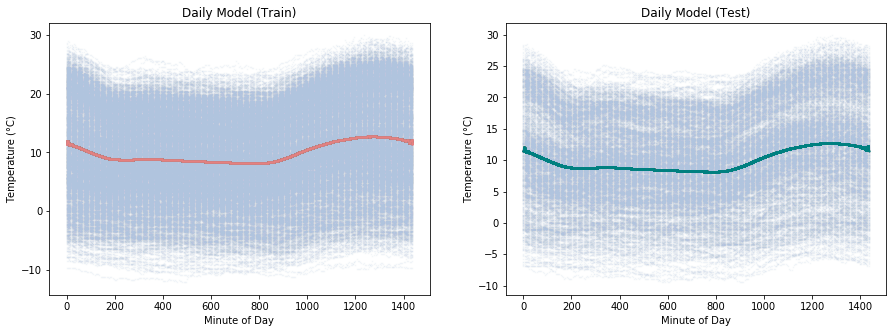

In [14]:
# plot daily model
fig, axs = plt.subplots(1, 2, figsize=(15,5))

# Training Data
axs[0].scatter(X_train['Minute'], y_train, 
               color='lightsteelblue', alpha=0.1, s = 0.5)
axs[0].scatter(daily_model[8], daily_model[9], 
               alpha=0.1, s=0.5, color='lightcoral')
axs[0].set_title('Daily Model (Train)')
axs[0].set_xlabel('Minute of Day')
axs[0].set_ylabel('Temperature (°C)')

# Testing Data
axs[1].scatter(X_test['Minute'], y_test, 
               color='lightsteelblue', alpha=0.1, s = 0.5)
axs[1].scatter(daily_model[10], daily_model[11], 
               alpha=0.1, s=0.5, color='teal')
axs[1].set_title('Daily Model (Test)')
axs[1].set_xlabel('Minute of Day')
axs[1].set_ylabel('Temperature (°C)')


plt.show()

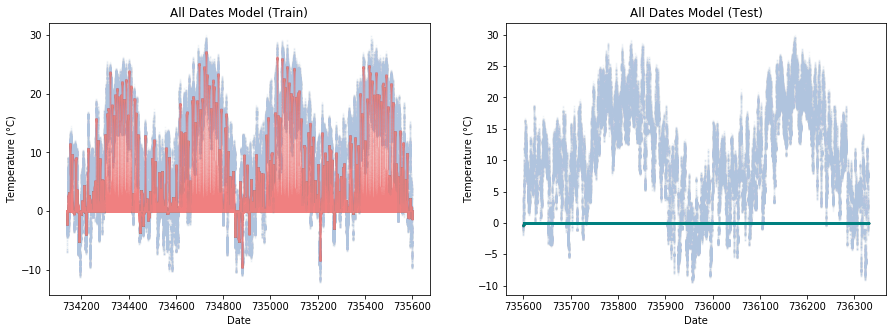

In [15]:
# plot daily model
fig, axs = plt.subplots(1, 2, figsize=(15,5))

# Training Data
axs[0].scatter(X_train['Date'], y_train, 
               color='lightsteelblue', alpha=0.1, s = 0.5)
axs[0].scatter(all_dates_model[8], all_dates_model[9], 
               alpha=0.1, s=0.5, color='lightcoral')
axs[0].set_title('All Dates Model (Train)')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature (°C)')

# Testing Data
axs[1].scatter(X_test['Date'], y_test, 
               color='lightsteelblue', alpha=0.1, s = 0.5)
axs[1].scatter(all_dates_model[10], all_dates_model[11], 
               alpha=0.1, s=0.5, color='teal')
axs[1].set_title('All Dates Model (Test)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature (°C)')


plt.show()

5. *Using $R^2$, quantify how your model performs on the testing data if you:*

    i. *Train with just the daily component of the model*

    ii. *Train with just the yearly component of the model*

    iii. *Train with the full model.*

In [16]:
print(f'Seasonal Model: R^2 = {seasonal_model[4]}, \
MSE = {seasonal_model[5]}')
print(f'Daily Model: R^2 = {daily_model[4]}, \
MSE = {daily_model[5]}')
print(f'All Dates Model: R^2 = {all_dates_model[4]}, \
MSE = {all_dates_model[5]}')

Seasonal Model: R^2 = 0.45736722098991855, MSE = 111.12389635671128
Daily Model: R^2 = 0.04489212576252821, MSE = 56.77158885899089
All Dates Model: R^2 = -1.8289738367593178, MSE = 166.5074782858589


The seasonal model had the highest score ($R^2=0.457$, $MSE=111$), but the daily model had a lower Mean Squared Error ($R^2=0.045$, $MSE=57$). Based on the $R^2$ score, the seasonal model performs better. The model including all dates did not perform well on unseen data (test data), resulting in an estimate of 0°C for all unseen dates.